In [1]:
import _init_paths

from tqdm import tqdm
import cv2
import torch
import numpy as np
import os

import pandas as pd
from detectors.detector_factory import detector_factory
from datasets.dataset_factory import get_dataset
from models.decode import ddd_decode
from utils.debugger import Debugger
from opts import opts

from matplotlib import pyplot as plt

In [2]:
from shutil import rmtree

In [3]:
from utils.image import transform_preds
from utils.post_process import get_alpha

In [42]:
MODEL_PATH = '../models/redsnapper_512_base_model.pth'
TASK = 'ddd'
DATASET = 'kitti'
IMG_PATH = '../data/kitti/images/trainval/000079.jpg'

In [43]:
Dataset = get_dataset(DATASET, TASK)

# config init
opt = opts().init('{} --load_model {}'.format(TASK, MODEL_PATH).split(' '))
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)

detector = detector_factory[opt.task](opt)
debugger = Debugger(dataset=detector.opt.dataset, ipynb=(detector.opt.debug==3),
                        theme=detector.opt.debugger_theme)

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  /home/alfin/Documents/deep_learning/production/CenterNet_fish/src/lib/../../exp/ddd/default
heads {'hm': 3, 'dep': 1, 'rot': 8, 'dim': 3, 'wh': 2, 'reg': 2}
heads {'hm': 3, 'dep': 1, 'rot': 8, 'dim': 3, 'wh': 2, 'reg': 2}
Creating model...
loaded ../models/redsnapper_512_base_model.pth, epoch 70


In [44]:
img_ori = cv2.imread(IMG_PATH)
img_ori = cv2.resize(img_ori,(512,512))

img = img_ori.copy()

img_input, meta = detector.pre_process(img, detector.scales)
img_input = img_input.to(detector.opt.device)

In [45]:
# Manual

In [46]:
torch.no_grad()
torch.cuda.synchronize()

In [47]:
output = detector.model(img_input)[-1]

In [48]:
output['hm'] = output['hm'].sigmoid_()
output['dep'] = 1. / (output['dep'].sigmoid() + 1e-6) - 1.
wh = output['wh'] if detector.opt.reg_bbox else None
reg = output['reg'] if detector.opt.reg_offset else None
torch.cuda.synchronize()

output.keys()

dict_keys(['hm', 'dep', 'rot', 'dim', 'wh', 'reg'])

In [49]:
for key in output.keys():
    print(key,output[key].shape)
    
# 96 = 384/4

hm torch.Size([1, 3, 128, 128])
dep torch.Size([1, 1, 128, 128])
rot torch.Size([1, 8, 128, 128])
dim torch.Size([1, 3, 128, 128])
wh torch.Size([1, 2, 128, 128])
reg torch.Size([1, 2, 128, 128])


In [50]:
# [xs, ys, scores, rot, depth, dim, wh, clses], dim=2)
# 0 xs
# 1 ys
# 2 scores
# 3-10 rot
# 11 depth
# 12-14 dim
# 15 w
# 16 h
# 17 class

# [xs, ys, scores, rot, depth, dim, wh, clses], dim=2)
# 0 xs
# 1 ys
# 2 scores
# 3-34 rot
# 35 depth
# 36-38 dim
# 39 w
# 40 h
# 41 class


dets = ddd_decode(output['hm'], output['rot'], output['dep'],
                          output['dim'], wh=wh, reg=reg, K=detector.opt.K)
dets = dets.detach().cpu().numpy()
dets.shape

(1, 100, 18)

In [51]:
# 2D Detection
# 0 xs
  # 1 ys
  # 2 scores
  # 3-18 rot
  # 19 depth
  # 20-22 dim
  # 23 w
  # 24 h
  # 25 class

In [52]:
# 0 xs
# 1 ys
# 2 scores
# 3-10 rot
# 11 depth
# 12-14 dim
# 15 w
# 16 h
# 17 class

In [53]:
down_ratio = debugger.down_ratio

for det in dets[0]:
    scores = det[2]
    class_name = int(det[-1])
    
    cx = int(det[0] * down_ratio)
    cy = int(det[1] * down_ratio)
    
    w = det[15] * down_ratio
    h = det[16] * down_ratio
    
    xmin = int(cx - w/2)
    ymin = int(cy - h/2)
    xmax = int(cx + w/2)
    ymax = int(cy + h/2)
    
    dim = list(det[12:15])
    
    depth = det[11]
    
    rot = det[3:11].reshape((1,8))
    if scores > 0.3:
#         merged = list()
#         merged += [xmin,ymin,xmax,ymax]
#         merged += (dim)
#         merged.append(depth)
#         merged.append(list(get_alpha(rot))[0])
#         merged.append(list(get_alpha(rot,is_alphay=True))[0])
#         merged.append(get_alpha(rot,is_alphay=True))
#         print(xmin,ymin,xmax,ymax)
#         print(depth)
#         print(get_alpha(rot))
#         print(get_alpha(rot,is_alphay=True))
#         print(merged)
#         print('')
        print(xmin,ymin,xmax,ymax,dim,depth)
        img = cv2.rectangle(img,(xmin,ymin),(xmax,ymax), (255,0,0), 2)
        img = cv2.circle(img, (cx,cy), radius=3, color=(0, 0, 255), thickness=-1)

345 367 506 506 [0.34372354, 0.6559192, 0.32578817] 0.92536783
145 305 224 350 [0.31569967, 0.5646548, 0.35125038] 1.7004001
192 5 243 70 [0.34478456, 0.605911, 0.38628384] 1.8572767
464 0 507 73 [0.31856436, 0.53638107, 0.40404] 1.2552798
429 342 508 467 [0.35691935, 0.66851324, 0.3070911] 1.3274362
263 0 320 78 [0.33820558, 0.67341226, 0.2685587] 2.3076878
230 138 273 209 [0.37924635, 0.7368785, 0.32887653] 2.7059157


In [54]:
np.degrees(6.078107018266813) - np.degrees(4.171337)

109.24987454877126

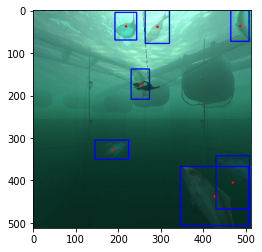

In [55]:
plt.imshow(img[...,::-1])
plt.show()

In [56]:
# 3D Detection

In [57]:
idx = np.arange(100) * (np.arange(100) > 50)
aa = np.arange(100) 
bb = np.arange(100)*2
bb

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198])

In [58]:
aa*idx + bb*(1-idx)

array([    0,     2,     4,     6,     8,    10,    12,    14,    16,
          18,    20,    22,    24,    26,    28,    30,    32,    34,
          36,    38,    40,    42,    44,    46,    48,    50,    52,
          54,    56,    58,    60,    62,    64,    66,    68,    70,
          72,    74,    76,    78,    80,    82,    84,    86,    88,
          90,    92,    94,    96,    98,   100, -2499, -2600, -2703,
       -2808, -2915, -3024, -3135, -3248, -3363, -3480, -3599, -3720,
       -3843, -3968, -4095, -4224, -4355, -4488, -4623, -4760, -4899,
       -5040, -5183, -5328, -5475, -5624, -5775, -5928, -6083, -6240,
       -6399, -6560, -6723, -6888, -7055, -7224, -7395, -7568, -7743,
       -7920, -8099, -8280, -8463, -8648, -8835, -9024, -9215, -9408,
       -9603])

In [59]:
img_dirs = '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/'
img_dirs = os.path.join(img_dirs,'all_frames')
if os.path.exists(os.path.join(img_dirs,'..','label_inference')):
    rmtree(os.path.join(img_dirs,'..','label_inference'))

os.makedirs(os.path.join(img_dirs,'..','label_inference'))
imgs = os.listdir(img_dirs)[:300]

# print(imgs)
for idx,img_path in enumerate(tqdm(imgs)):
    img_ori = cv2.imread(os.path.join(img_dirs,img_path))
    img_ori = cv2.resize(img_ori,(512,512))
    
    img = img_ori.copy()

    img_input, meta = detector.pre_process(img, detector.scales)
    img_input = img_input.to(detector.opt.device)

    torch.no_grad()
    torch.cuda.synchronize()

    output = detector.model(img_input)[-1]

    output['hm'] = output['hm'].sigmoid_()
    output['dep'] = 1. / (output['dep'].sigmoid() + 1e-6) - 1.
    wh = output['wh'] if detector.opt.reg_bbox else None
    reg = output['reg'] if detector.opt.reg_offset else None
    torch.cuda.synchronize()

    output.keys()

    dets = ddd_decode(output['hm'], output['rot'], output['dep'],
                              output['dim'], wh=wh, reg=reg, K=detector.opt.K)
    dets = dets.detach().cpu().numpy()

    down_ratio = debugger.down_ratio
    
    out = list()
    
    for det in dets[0]:
        scores = det[2]
        class_name = int(det[-1])

        cx = int(det[0] * down_ratio)
        cy = int(det[1] * down_ratio)

        w = det[15] * down_ratio
        h = det[16] * down_ratio

        xmin = int(cx - w/2)
        ymin = int(cy - h/2)
        xmax = int(cx + w/2)
        ymax = int(cy + h/2)

        dim = list(det[12:15])

        depth = det[11]

        rot = det[3:11].reshape((1,8))
        if scores > 0.2:
            merged = list()
            merged += [xmin,ymin,xmax,ymax]
            merged += (dim)
            merged.append(depth)
            merged.append(list(get_alpha(rot))[0])
            merged.append(0)
            out.append(merged)
        
    df = pd.DataFrame(out,columns=['xmin','ymin','xmax','ymax','h','w','l','z','alphay','alphax'])
    if len(df)==0:
        print(idx)
    df.to_csv(os.path.join(img_dirs,'..','label_inference',os.path.splitext(os.path.basename(img_path))[0]+'.txt'),header=False,sep=' ',index=False)
        

  2%|█▌                                                               | 7/300 [00:00<00:09, 30.05it/s]

1
5


  5%|███▏                                                            | 15/300 [00:00<00:09, 31.27it/s]

8
10


  8%|████▉                                                           | 23/300 [00:00<00:08, 31.75it/s]

16
17
21


  9%|█████▊                                                          | 27/300 [00:00<00:08, 31.96it/s]

23
28


 16%|██████████                                                      | 47/300 [00:01<00:07, 32.72it/s]

43
45


 18%|███████████▋                                                    | 55/300 [00:01<00:07, 32.52it/s]

50
52
53


 21%|█████████████▍                                                  | 63/300 [00:01<00:07, 31.88it/s]

58
63


 24%|███████████████▏                                                | 71/300 [00:02<00:07, 31.43it/s]

65
68


 26%|████████████████▊                                               | 79/300 [00:02<00:06, 32.32it/s]

72
75


 28%|█████████████████▋                                              | 83/300 [00:02<00:06, 32.25it/s]

79
82


 32%|████████████████████▎                                           | 95/300 [00:02<00:06, 32.52it/s]

91
93
94
96


 36%|██████████████████████▍                                        | 107/300 [00:03<00:05, 32.90it/s]

101
102
103


 38%|████████████████████████▏                                      | 115/300 [00:03<00:05, 32.61it/s]

108
113
114


 42%|██████████████████████████▋                                    | 127/300 [00:03<00:05, 31.80it/s]

120
121


 45%|████████████████████████████▎                                  | 135/300 [00:04<00:05, 31.91it/s]

128
130
132
134


 46%|█████████████████████████████▏                                 | 139/300 [00:04<00:05, 31.59it/s]

135
137
138


 49%|██████████████████████████████▊                                | 147/300 [00:04<00:04, 31.67it/s]

142
145
147


 52%|████████████████████████████████▌                              | 155/300 [00:04<00:04, 31.17it/s]

149
152
153


 56%|███████████████████████████████████                            | 167/300 [00:05<00:04, 31.62it/s]

160


 58%|████████████████████████████████████▊                          | 175/300 [00:05<00:03, 31.27it/s]

169
170
174


 61%|██████████████████████████████████████▍                        | 183/300 [00:05<00:03, 31.34it/s]

178
184


 64%|████████████████████████████████████████                       | 191/300 [00:05<00:03, 31.94it/s]

186
188
191
192


 66%|█████████████████████████████████████████▊                     | 199/300 [00:06<00:03, 32.36it/s]

193
196


 69%|███████████████████████████████████████████▍                   | 207/300 [00:06<00:02, 32.65it/s]

203
205
206


 73%|█████████████████████████████████████████████▉                 | 219/300 [00:06<00:02, 32.82it/s]

212
214


 77%|████████████████████████████████████████████████▌              | 231/300 [00:07<00:02, 31.64it/s]

225
228


 81%|███████████████████████████████████████████████████            | 243/300 [00:07<00:01, 32.31it/s]

236
241


 82%|███████████████████████████████████████████████████▊           | 247/300 [00:07<00:01, 32.40it/s]

243
245


 85%|█████████████████████████████████████████████████████▌         | 255/300 [00:07<00:01, 32.14it/s]

250


 89%|████████████████████████████████████████████████████████▎      | 268/300 [00:08<00:01, 24.08it/s]

262
263


 92%|██████████████████████████████████████████████████████████▏    | 277/300 [00:08<00:00, 26.58it/s]

273
275


 94%|███████████████████████████████████████████████████████████▍   | 283/300 [00:09<00:00, 24.76it/s]

279


 96%|████████████████████████████████████████████████████████████▋  | 289/300 [00:09<00:00, 24.05it/s]

284


100%|███████████████████████████████████████████████████████████████| 300/300 [00:10<00:00, 29.35it/s]
